# Memory managment in HIP

In previous lessons we have looked at straightforward ways in which memory was allocated on the host and then copied to the device for use as global memory by the kernel. In the introduction we briefly covered the five different memory spaces that are available to a HIP Program and if they can be accessed from the host or the kernel.

* Host 
* Global
* Local 
* Private 
* Constant 

**Host memory** is usually the largest and slowest memory space on the host, and **global memory** is the largest and slowest memory space available on the compute device. **Local** and **Constant** memory is usually located in the small and fast caches on the compute device. **Private memory** is usually located in the registers, which are the fastest and smallest memory spaces available on the compute device. A programmer has some degree of control over where memory is stored during the operation of a HIP program. The diagram below shows what memory is available for access by both host and kernel threads at runtime. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

Kernel threads can access *global*, *constant*, *local* and *private* memory, whereas host threads can only access *host* and *global* memory. Private memory for a kernel thread is exclusive to the kernel, meaning that no other kernel can access the same private memory. Local memory is accessible to all kernel threads in a workgroup, but not to kernel threads from another workgroup. *Global* and *Constant* memory is accessible from all kernel threads.

## Load checking data

In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

# Load the size of the matrix from file
NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)

## Memory access from the host

From the introduction we know that buffers are allocated on the compute device and memory is copied between host and buffer as they are needed. Here are some additional ways we can create buffers on the host and transfer memory. 

### Pitched memory allocations

Thus far we have been creating buffers with the **hipMalloc** function. For example, this code creates a buffer that has read-write access from the kernel. The buffer is resident on the compute device.

```C++
    float* A_d;
    H_ERRCHK(hipMalloc((void**)&A_d, nbytes_A));
```

This approach is applicable to multi-dimensional arrays, however access in a multi-dimensional way may not result in **optimal** usage of the cache hierarchy. If we define a `pencil` as the dimension along which memory is contiguous (this could be along dimension 0 for column-major access and along the last dimension for row-major access), then cache accesses are *optimised* if each pencil of a multi-dimensional allocation can be aligned to a multiple of the cache line size, typically a multiple of 64 bytes. A **pitched memory** allocation is one where each pencil of the allocation is **padded** so that each pencil begins on an **alignment boundary**. Shown below is a diagram of a pitched memory allocation. Each pencil of the allocation has a desired **width** (in bytes), however every pencil needs to have a multiple of **alignment** bytes in it (at the time of writing the AMD documentation says the alignment is 128 bytes). Therefore each pencil is padded to a size of **pitch** (bytes) so the next pencil can begin on an alignment boundary. In the allocation there is **height** pencils.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/pitched_memory.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Allocation of pitched memory, where the length of each "pencil" is a multiple of the alignment.</figcaption>
</figure>

It is important to note that the entire allocation is still **contiguous**, however each pencil has a **pitch** that may be different to its desired **width**. This means that when constructing a strides vector and indexing into an array, one has to use the pitch instead of width. For example for a given set of coordinates (i0, i1), where each element uses **b** bytes, and we are using row-major ordering, then the position into the allocation is given as:

$$
\mbox{p} = \mbox{i0} \frac{\mbox{pitch}}{\mbox{b}} + \mbox{i1},
$$

instead of

$$
\mbox{p} = \mbox{i0} \times \mbox{N} + \mbox{i1},
$$

where N is the number of elements along a row, or **width**/b. 

In the program [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) we allocate pitched memory for **A_d** using the call to **hipMallocPitch** as follows:

```C++
    float *A_d, *B_d, *C_d;
    size_t pitch_A;
    
    // Allocate A using pitched memory
    H_ERRCHK(
        hipMallocPitch(
            (void**)&A_d,
            &pitch_A, // actual given width of pencils
            // requested pencil width (bytes)
            N1_A*sizeof(float),
            // Height is the number of pencils to allocate for
            N0_C
        )
    );
```

The call will fill **pitch_A** with the actual width of each pencil in the allocation. Then when we access **A** in the kernel, we have to ensure that we use **pitch_A/sizeof(float)** instead of **N1_A** for the stride in dimension 0. We pass **pitch_A** to the kernel as an extra parameter,

```C++
    // Launch the kernel using hipLaunchKernelGGL method
    // Use 0 when choosing the default (null) stream
    hipLaunchKernelGGL(mat_mult, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            pitch_A,
            N1_A,
            N0_C,
            N1_C
    );
```

then within the kernel we use **pitch_A_N = pitch_A/sizeof(float)** instead of the stride **N1_A** when accessing A.

```C++
// standard matrix multiply kernel 
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C,
        size_t pitch_A, // The pitch of A (in bytes)
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
    
    // pitch_A_N is the pitch of A in elements
    size_t pitch_A_N = pitch_A/sizeof(float);
    
    // Code left out for brevity
    ....
        
        // Loop over columns of A and rows of B
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*pitch_A_N+n]*B[i1+n*N1_C]; 
        }
        
        // Set the value in C at offset
        C[offset]=temp;
    }
}
```

### Filling buffers

Sometimes you might want to intialise a buffer with a value before using it. The functions **hipMemset** and **hipMemsetAsync** take care of the process of filling a HIP memory allocation. In [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) we use **hipMemset** to fill a pitched memory allocation with zeros. When using pitched memory, care must be taken to ensure that we calculate the **actual size** of the memory using the pitch.

```C++
    // Initialise pitched memory with a value
    H_ERRCHK(
        hipMemset(
            A_d, // The pointer to set
            0, // The value to fill
            pitch_A*N0_C // Number of bytes to fill
        )
    );
```

### Zero-copy allocations

Zero-copy allocations are way to blur or even erase the boundary between host memory and device memory, thus avoiding the need for explicit memory transfers. This means that the same allocation is visible from both the host and the compute device. In the diagram below we see that a zero-copy allocation is visible to the host and the compute device at the same time.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/memory_spaces_zero_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Access to memory from kernel and host threads.</figcaption>
</figure>

#### Zero-Copy allocations with pinned memory

Pinned memory is a memory allocation that lives on the host with flags set so the memory **cannot be paged out to disk**. Pinning enables Direct Memory Access (DMA) transfers between host and device that bypass the CPU, and can therefore be fast and efficient. The OS usually limits amount of pinned memory because large pinned memory allocations will put the OS under stress if resources run out. It is **good practice** to use pinned memory for allocations on the host that will be the source or destination for **frequent transfers** between host and device. 

Pinned memory may be **used from the compute device directly (zero-copy memory)** if the **hipHostGetDevicePointer** function is used to map a host pointer into the memory space of the compute device. During kernel invocation, memory that is accessed by the device is streamed into the device and updates are propagated back to host memory when the kernel is finished. 

##### Allocating pinned host memory

In [mat_mult_pinned_mem.cpp](mat_mult_pinned_mem.cpp) we use the HIP function **hipHostMalloc** to allocate `pinned memory` for the host arrays **A_h**, **B_h**, and **C_h**. 

```C++
    // Allocate pinned memory for the host arrays
    float *A_h, *B_h, *C_h;
    H_ERRCHK(
        hipHostMalloc(
            (void**)&A_h, 
            nbytes_A, 
            hipHostMallocDefault | hipHostMallocNumaUser
        )
    );
    H_ERRCHK(
        hipHostMalloc(
            (void**)&B_h, 
            nbytes_B,
            hipHostMallocDefault | hipHostMallocNumaUser
        )
    );
```

There are a number of flags that are available when allocating pinned memory. Here is what they mean:

| Flag | Purpose |
| :--- | :--- |
|hipHostMallocCoherent| Allocate coherent memory, fine-grained synchronisation but slower. Synchronisation between host and device is guaranteed at all stream and device synchronisation calls as well as event synchronisation calls.|
|hipHostMallocNonCoherent| Allocate non-coherent memory for performance, synchronisation between host and device is only guaranteed after a call to **hipStreamSynchronize** or **hipDeviceSynchronize**.|
|hipHostMallocNumaUser| Use the user-defined NUMA policy when allocating memory. This might be useful for architectures like AMD EPYC, where L3 cache is localised to chiplets.|
|hipHostMallocMapped| Map the allocation into the address space for the current device. |
|hipHostMallocPortable | Memory is considered allocated in all contexts. Memory may be portably accessed by all devices.|
|hipHostMallocWriteCombined| Combine writes for performance. Not performant for reads from the CPU however.|
|hipHostMallocDefault| Combination of Mapped, Portable, and Coherent flags, the default. |

The **hipHostMallocCoherent** and **hipHostMallocNonCoherent** flags are mutually exclusive. 

Memory allocated with **hipHostMalloc** must be released with **hipHostFree**, as shown at the end of the program.

```C++
    // Clean up memory that was allocated on the read   
    H_ERRCHK(hipHostFree(A_h));
    H_ERRCHK(hipHostFree(B_h));
```

> Notice that the memory allocations are labelled **A_h**, and **B_h**. The **_h** suffix in the name of the allocation is just *naming convention* to highlight that the memory is allocated on the host. 

##### Registering (pinning) an existing allocation on the host

We can also `pin` an ordinary allocation directly using the **hipHostRegister** command. Here we use **h_alloc** to allocate host memory for C and register that memory for use as Zero-copy memory in the kernel.

```C++
    // Allocate C_h in the normal way
    // But then register (pin) it!
    C_h = (float*)h_alloc(nbytes_C);
    
    // Register (pin) matrix C for use in the kernel
    H_ERRCHK(hipHostRegister(C_h, nbytes_C, hipHostRegisterDefault));
```

As with **hipHostMalloc**, there are a number of flags available for registering memory.

| Flag | Purpose |
| :--- | :--- |
|hipHostRegisterMapped| Map the allocation into the address space for the current device. |
|hipHostRegisterPortable | Memory is considered allocated in all contexts. Memory may be portably accessed by all devices.|
|hipHostRegisterDefault| Combination of Mapped and Portable flags, the default. |


The [AMD documentation]() strongly advises that **host allocations that are registered** should be aligned to a multiple of the cache line size. Experience with OpenCL suggests that this is essential. The function **h_alloc** allocates memory that is aligned to the least common multiple of the L1 cache line size and the size of **ulonglong4**, which is the largest vector datatype available in HIP.

When we are done with the registered host allocation we must then unregister it.

```C++
    // Unregister host memory
    H_ERRCHK(hipHostUnregister(C_h));
```

##### Using pinned memory in a kernel

Before we can use pinned memory from a kernel we must map the memory allocation into the memory space of the compute device. The function **hipHostGetDevicePointer** does this, 

```C++
    float *A_d, *B_d, *C_d;
    H_ERRCHK(hipHostGetDevicePointer((void**)&A_d, A_h, 0));
    H_ERRCHK(hipHostGetDevicePointer((void**)&B_d, B_h, 0));
    H_ERRCHK(hipHostGetDevicePointer((void**)&C_d, C_h, 0));
```

Then one can use the mapped device pointers directly in the kernel launch as follows:

```C++
    // Launch the kernel using hipLaunchKernelGGL method
    // Use 0 when choosing the default (null) stream
    hipLaunchKernelGGL(mat_mult, 
            grid_nblocks, 
            block_size, sharedMemBytes, 0, 
            A_d, B_d, C_d,
            N1_A,
            N0_C,
            N1_C
    );
```

With pinned memory you must access the allocation from the host **using the host pointer** and the allocation on the device using the device pointer. One **must not use hipFree** to free the mapped device pointer though! Use the **hipHostFree** command instead to free the host memory.

##### Testing the pinned memory allocation

In [2]:
!make; ./mat_mult_pinned_mem.exe

make: Nothing to be done for 'all'.
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    402 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 1.14441e-05


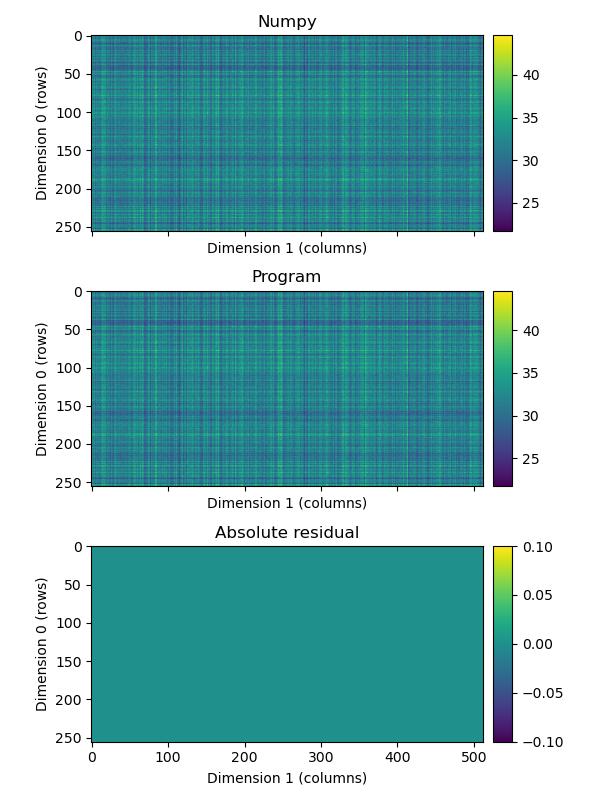

In [3]:
mat_mul.load_data()
mat_mul.check_data()

#### Zero-copy allocations with managed memory.

Managed memory is another form of allocating memory that is accessible from **both the host and the compute device**. Managed memory leaves it to the runtime to `manage` or cache pages of memory on either the host or the compute device, and shuffle memory between host and device as required. Instead of separate pointers to access from the host or the device, as with pinned memory, just **one pointer** can be used for both modes of access.

In the program [mat_mult_managed_mem.cpp](mat_mult_managed_mem.cpp) we use managed memory to store matrices **A**, **B**, and **C**. Not every HIP device has support for managed memory, and we check for managed memory support with the following call to **h_check_managed** in <a href="../include/hip_helper.hpp">hip_helper.hpp</a>.

```C++
    // Check to make sure managed memory can be allocated
    h_check_managed_mem(dev_index);
```

In <a href="../include/hip_helper.hpp">hip_helper.hpp</a> the function **h_check_managed** has the following code:

```C++
/// Check to see if device supports managed memory, exit if it does not
void h_check_managed(int dev_index) {
    // Check to make sure managed memory access is supported
    int managed_capability = 0;
    H_ERRCHK(
        hipDeviceGetAttribute(
            &managed_capability,
            hipDeviceAttributeManagedMemory, 
            dev_index
        )
    );
    if (!managed_capability) {
        std::printf("Sorry, device %d cannot allocate managed memory\n", dev_index);
        exit(EXIT_FAILURE); 
    }    
}
```

Then we allocate managed memory using the call to **hipMallocManaged** as follows:

```C++
    // Allocate pinned memory for the host arrays
    float *A_m, *B_m, *C_m;
    H_ERRCHK(
        hipMallocManaged(
            (void**)&A_m, 
            nbytes_A, 
            hipMemAttachGlobal
        )
    );
    H_ERRCHK(
        hipMallocManaged(
            (void**)&B_m, 
            nbytes_B, 
            hipMemAttachHost
        )
    );
    H_ERRCHK(
        hipMallocManaged(
            (void**)&C_m, 
            nbytes_C
        )
    );
```

Two different flags are used here during a call to **hipMallocManaged**. The flag **hipMemAttachGlobal** means the memory can be accessed by any stream on any device. The flag **hipMemAttachHost** appears to mean that the memory is initially allocated on the host. No flag means **hipMemAttachGlobal**, which is the default. 

After allocting memory we need no additional steps to use the memory from within a kernel. Deallocation of managed memory is performed with a call to **hipFree**.

```C++
    // Clean up managed memory on the host   
    H_ERRCHK(hipFree(A_m));
    H_ERRCHK(hipFree(B_m));
    H_ERRCHK(hipFree(C_m));
```

##### Testing the managed memory allocation

In [4]:
!make; ./mat_mult_managed_mem.exe

make: Nothing to be done for 'all'.
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    402 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 1.14441e-05


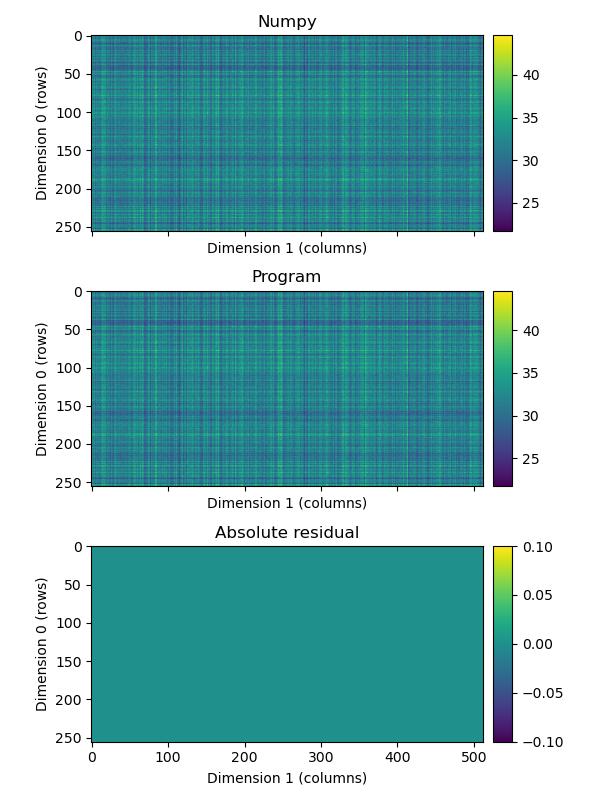

In [5]:
mat_mul.load_data()
mat_mul.check_data()

### Explicit memory transfers in HIP

Sometimes using pinned or managed memory is neither performant or available and you need to resort to explicit memory movement techniques to copy memory between host and device. When copying memory in HIP you have the option of copying either **contiguous** or **rectangular** regions of allocated memory, and the option of using either regular (blocking) or asynchronous (non-blocking) transfers. By rectangular I mean that if the memory allocation is interpreted as **folded into a multidimensional array**, then a rectangular copy would copy a **rectangular region** of that array.

#### Contiguous memory copies

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/contiguous_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Contiguous memory copy.</figcaption>
</figure>

If you only need to copy contiguous chunks of memory, then **hipMemcpy** is available to help with that. The usage and flags for **hipMemcpy** is covered in the matrix multiplication example from Lesson 3. The command **hipMemcpyAsync** is the asychronous complementary function to **hipMemcpy**, it takes as an extra argument the **stream** in  which you would like the work to take place, and will only **return immediately** if the host memory you are copying from/to is **pinned**, i.e it is allocated with **hipHostMalloc**.

#### Rectangular copies

Sometimes a contiguous copy is not sufficient, such as when you need to copy rectangular boundary areas of a multi-dimensional array. The functions **hipMemcpy3D** and **hipMemcpy3DAsync** can copy 1D, 2D and 3D rectangular regions in memory allocations while keeping track of things like memory pitch. 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/rectangular_memory_copy.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

The function **hipMemcpy3D** takes one argument of type **hipMemcpy3DParms**, however it is a complex structure to fill. In the code [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) is an example where we use **hipMemcpy3D** to copy from matrix **C_d** to **C_h**. First we need to make pitched pointers for the host and device allocations. We can use the function **make_hipPitchedPtr** to do this. In order to make a pitched pointer we need the: 

* **pointer** to the memory allocation,
* the **pitch** (or length of each pencil in bytes),
* the requested pencil **width** (in elements),
* and the number of pencils allocated. 

We do this in code as follows:

```C++
    // Create pitched pointers 
    // For the host
    hipPitchedPtr C_h_ptr = make_hipPitchedPtr(
        C_h, // pointer 
        N1_C*sizeof(float), // pitch - actual pencil width (bytes) 
        N1_C, // requested pencil width (elements)
        N0_C // total number of pencils in the allocation (elements)
    );
    // For the device
    hipPitchedPtr C_d_ptr = make_hipPitchedPtr(
        C_d, // pointer
        N1_C*sizeof(float), // pitch - actual pencil width (bytes) 
        N1_C, // requested pencil width (elements)
        N0_C // total number of pencils (elements)
    );
```

Next, we need the starting position for the memory copy in each allocation. The function **make_hipPos** takes in the arguments:

* Position along a pencil (in bytes)
* Starting pencil index (elements)
* Starting pencil plane index (elements)

We deploy this function in [mat_mult_pitched_mem.cpp](mat_mult_pitched_mem.cpp) for the memory copy:

```C++
    // Postion within the host array
    hipPos C_h_pos = make_hipPos(
        0*sizeof(float), // byte position along a pencil (bytes)
        0, // starting pencil index (elements)
        0 // start pencil plane index (elements)
    );
    // Postion within the device array
    hipPos C_d_pos = make_hipPos(
        0*sizeof(float), // byte position along a pencil (bytes)
        0, // starting pencil index (elements)
        0 // starting pencil plane index (elements)
    );
```

Lastly, we need the **extent** or region of memory to copy. The function **make_hipExtent** takes the arguments:

* Width along a pencil to copy (in bytes)
* Number of pencils to copy in a pencil plane
* Number of pencil planes to copy

Then we create and fill a structure of type **hipMemcpy3DParms** using the data structures created above and call the function **hipMemcpy3D**.

```C++
    // Fill the copy parameters
    hipMemcpy3DParms copy_parms = {0};
    copy_parms.srcPtr = C_d_ptr;
    copy_parms.srcPos = C_d_pos;
    
    copy_parms.dstPtr = C_h_ptr;
    copy_parms.dstPos = C_h_pos;
    
    copy_parms.extent = extent;
    copy_parms.kind = hipMemcpyDeviceToHost;
```

The memcpy flags we can use for **kind** are:

* hipMemcpyHostToHost
* hipMemcpyHostToDevice
* hipMemcpyDeviceToHost
* hipMemcpyDeviceToDevice
* hipMemcpyDefault

Finally, we perform the copy with **hipMemcpy3D** and **copy_parms**.

```C++
    H_ERRCHK(hipMemcpy3D(&copy_parms));
```

As with contiguous memory copies, the rectangular copy function **hipMemcpy3D** has an asynchronous partner function **hipMemcpy3DAsync** that takes in a stream as an extra argument and the copy will be submitted to that stream. As with asynchronous contiguous copies, the host allocation **needs to be pinned** in order for a copy to be truly asynchronous and return immediately.

#### Fast copies between compute devices

When performing memory transfers between compute devices you can enable **peer-to-peer** memory transfers using the **hipDeviceEnablePeerAccess** function . Otherwise memory transfers that use the **hipMemcpyDeviceToDevice** flag will still work, but they will use a slower method of transferring using a host memory allocation as an intermediary.

#### Testing explicit memory transfers

We run the program that uses pitched memory and check the result.

In [6]:
!make; ./mat_mult_pitched_mem.exe

make: Nothing to be done for 'all'.
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    402 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 1.14441e-05


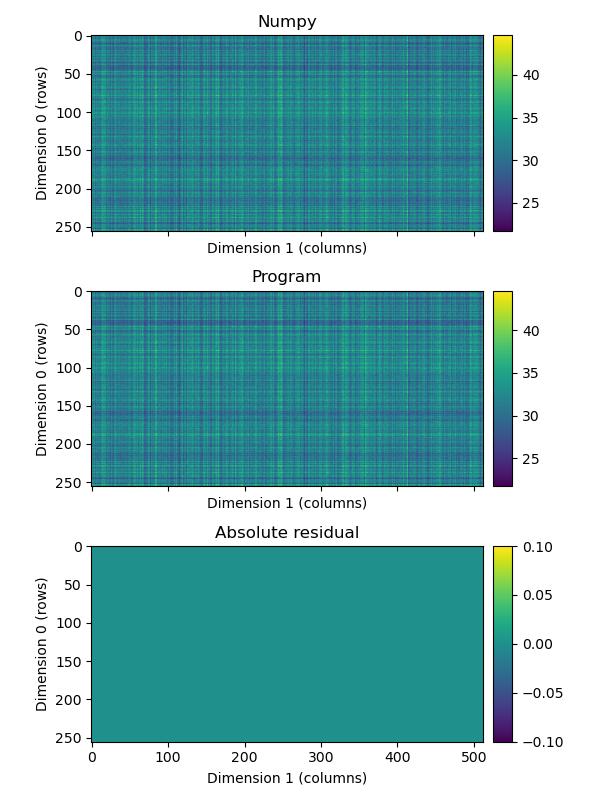

In [7]:
mat_mul.load_data()
mat_mul.check_data()

## Memory control and access from kernels

Kernels have access to the following memory spaces on a compute device:

* Private memory (read-write memory stored registers)
* Shared memory (read-write memory stored on fast cache)
* Global memory (read-write main memory on device)
* Constant memory (read-only memory in fast cache)
* Texture memory (fast read-only access)
* L1 and L2 cache (automatically managed, but kernels can influence)

In this section we explore how to utilize each memory space from within a kernel.

### Global address space

Allocations of memory in the **global address space** 

```C
// kernels_mat_mult.c source

// Matrix multiply kernel that uses local memory for B
__kernel void mat_mult_local (
                        __global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

It is interesting that for the memory allocations brought into the kernel we can use any number of pointer types to interpret the memory. For example we can change the pointer type for **A** and **B** to **float8\*** and interpret the input arrays as elements of type **float8**

```C
__kernel void mat_mult_local (
                        __global float8* A, 
                        __global float8* B, 
                        __global float* C,
                        __local  float8* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

Of course we need to ensure that we don't go off the end of the array, and that the number of floats allocated for the buffers being passed in is a multiple of the vector length (8 in this instance). 

Variables in the global address space can also be declared **outside kernel functions** if the **\_\_opencl_c_program_scope_global_variables** macro is defined.

```C
// kernels_mat_mult.c source

// Example of a global variable
#ifdef __opencl_c_program_scope_global_variables
__global int a_g = 2; 
__global float b_g[2] = {2.0,1.0}; 
#endif

// standard matrix multiply kernel 
__kernel void mat_mult_local (__global float* A,... 
```

If **a_g** and **b_g** are defined, then the variables are available to every kernel that runs in the program on the compute device.

### Constant address space

The constant address space is usually located in a fast cache and is defined by the **\_\_constant** or **constant** address qualifer. This makes it ideal for storing small (~16-128 KB) allocations of memory that must be accessible to all kernels (filter coefficients for example). The **clinfo** command shows you how much constant memory is available on each device.

In the source file [kernels_mat_mult.c](kernels_mat_mult.c) we define a couple of variables in the constant memory space

```C
// Example of constant memory
__constant float pi = 3.1415;
__constant float coeffs[] = {1.0, -2.0, 1.0};
```

Then we can use the constant variable **pi** within the **mat_mult_local** kernel as follows:
```C
// Scratch variable whose allocation uses constant memory
float temp=0.0*pi; 
```

### Local address space

Memory in the **local** address space is `local` to every work-item in the workgroup, meaning every work-item in the workgroup can access the memory, but work-items in another workgroup cannot. Local memory is specified with the **\_\_local** or **local** qualifier in front of the variable type at declaration (which happens either in a kernel function or in the kernel function preamble). Local memory is often provided by fast caches on the compute device and **might** provide a speed boost by virtue of being in close proximity (in terms of latency and bandwidth) to the processing elements. Having said that, the devices in OpenCL implementations are adept at caching global memory to fast caches anyway, so you might not always see a performance boost by using local memory.

There are two ways to allocate local memory, **static** and **dynamic** allocation:

#### Static allocation of local memory

Static allocations of local memory happen within the body of the kernel function. For example, in the code [kernels_mat_mult.c](kernels_mat_mult.c) we allocate an array of 10 floats that is available to every work-item in the workgroup.

```C++
    // kernels_mat_mult.c source
    // Make a local scratch array for demonstration purposes
    // (not actually used)
    __local float scratch[10];
```

Static allocations of local memory must happen in the outermost scope within the function, this means every work-item has to execute the allocation. Some implementations will not let you hide the allocation in a code block, and you also cannot allocate local memory within functions that are called from kernels.

#### Dynamic allocation of local memory

Local memory for a workgroup may also be dynamically reserved when the kernel is **enqueued**. Allocations to local memory are brought into a kernel as an argument with the **\_\_local** (or **local**) address qualifier, as can be seen with the **shared_B** local memory allocations in the **mat_mult_local** kernel, in [kernels_mat_mult.c](kernels_mat_mult.c).

```C++
// kernels_mat_mult.c source

__kernel void mat_mult_local (
                        __global float* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
```

The amount of local memory to allocated is specified at runtime by the [clSetKernelArg](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSetKernelArg.html) function. In the [mat_mult_local.cpp](mat_mult_local.cpp) sources we specify how much memory is to be allocated for **shared_B**. Notice that the last pointer argument is NULL, whereas it usually points to a buffer or variable.

```C++
    // mat_mult_local.cpp source

    // Set shared memory in argument 3 for shared_B
    // Local size is going to be (local_size[0], N1_A)
    H_ERRCHK(clSetKernelArg(kernel, 3, local_size[0]*N1_A*sizeof(cl_float), NULL ));
```


#### Example, matrix multiplication with local memory

There is an opportunity to employ local memory within the matrix multiplication example. A workgroup is of size **(L0, L1)**. Every work item in a row of a workgroup needs access to the same row of matrix A, and every column in the workgroup needs access to the same column of matrix B. If the workgroup prefetches these rows and columns into local fast caches, then there is potential to save time on fetches from global memory. Using the dynamic memory allocation method above we allocate a local memory space **shared_B** to store the columns of B that will be used by the workgroup. The local memory allocation is of size (L1, N1_A).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_local.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using a naive local memory implementation in matrix multiplication.</figcaption>
</figure>

We divide the local memory space into blocks of elements along dimension 1 so that every work-item can be responsible for filling a portion of the shared spaces. There are **L0** blocks (along dimension 1) to copy for **shared_B**. The kernel code for filling the shared memory is below.

```C++

    // kernels_mat_mult.c source

    // start and end
    size_t start, end;
    
    // Fill shared_B
    
    // Get the start and end lengths
    get_start_end(L0, N1_A, s0, &start, &end);
    // Fill the columns of shared with B
    if (i1<N1_C) {
        for (size_t n=start; n<end; n++) {
            shared_B[s1*N1_A+n]=B[i1+n*N1_C]; 
        }
    }
    
    // Enqueue a local barrier to make sure all the work items finish
    barrier(CLK_LOCAL_MEM_FENCE);
```

We use a kernel function called **get_start_end** to get the start and end indices of a block along dimension 1 of shared memory. Then we use a loop to fill the **shared_B** from matrix B on the device. 

##### **Work item synchronisation**

Work items in a workgroup will often finish work before others, however in order to keep in sync (and avoid a data race) they need to be made to **wait** until that all other work items have finished. A call to the inbuilt OpenCL kernel function **barrier** with the **CLK_LOCAL_MEM_FENCE** ensures that local memory is consistent amongst the workgroup before proceeding.

```C++

    // kernels_mat_mult.c source
    
    // Enqueue a local barrier to make sure shared memory is filled
    barrier(CLK_LOCAL_MEM_FENCE);
```

If you also need to ensure global memory is consistent at a barrier within a workgroup you can use the **CLK_GLOBAL_MEM_FENCE** flag with the **barrier** call.

> The absence of a barrier is often a source of bugs. Work-items executed on GPU's operate in lock-step and in thread teams, so consistency between work-items and local memory is somewhat less of an issue (unless multiple thread teams are present in a workgroup). On CPU's however, the work items are more independent, therefore a barrier is **critical** to maintaining consistency when working with local memory.

After the barrier, **shared_B** is now populated and available for all work-items. While performing the matrix operation we draw from the local memory allocations instead of global memory 

```C++
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // shared_B is of size (L1, N1_A)
            // C is of size (N0_C, N1_C)
            
            // Loop across row i0 of A
            // and across row s1 of shared_B
            temp+=A[i0*N1_A+n]*shared_B[s1*N1_A+n]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

The matrix multiplication code in [mat_mult_local.cpp](mat_mult_local.cpp) and the kernel **mat_mult_local** in [kernels_mat_mult.c](kernels_mat_mult.c) are using the local memory implementation. Feel free to run the example again to verify that it works!

##### **Running the application**

In [8]:
!make mat_mult_local.exe; ./mat_mult_local.exe

hipcc -g -fopenmp -O2 -I../include mat_mult_local.cpp -o mat_mult_local.exe 
mat_mult_local.cpp:17:10: fatal error: 'cl_helper.hpp' file not found
#include "cl_helper.hpp"
         ^~~~~~~~~~~~~~~
1 error generated when compiling for gfx1035.
make: *** [Makefile:19: mat_mult_local.exe] Error 1
/bin/bash: line 1: ./mat_mult_local.exe: No such file or directory


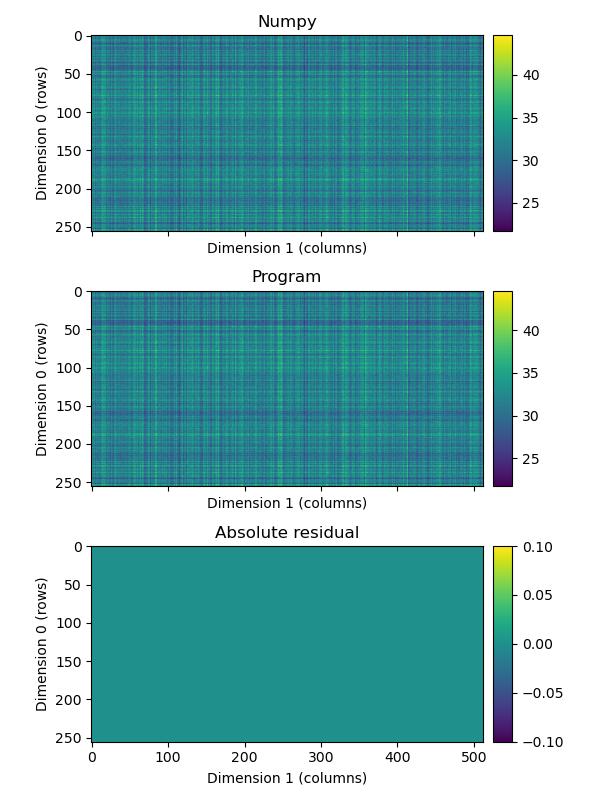

In [9]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A=defines["NCOLS_A"]
NROWS_C=defines["NROWS_C"]
NCOLS_C=defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.load_data()
mat_mul.check_data()

### Private memory

Private memory is the default storage space for variables created inside a running kernel. This memory is only available to the work item that allocates it. One does not need to use the **__private** (or **private**) qualifier as variables created in kernels are **private** by default. For example, in the **mat_mult** kernel in [kernels_mat_mult.c](kernels_mat_mult.c) we declare a private variable **temp** for use in the matrix dot products.

```C++
    // Scratch variable whose allocation uses constant memory pi
    float temp=0.0*pi;
```

Private memory is usually allocated from the fastest register memory on the device, but the  amount of available register memory is very small. If a kernel uses more register memory than there are variables, then register memory can spill over into global memory at the cost of performance.



### Generic addresses

Generic address spaces is an OpenCL 2.0 feature that enables functions called from kernels to accept pointer arguments from private, local, and global address spaces without having to qualify the address space they come from. Generic addresses are become available if the OpenCL implementation is 2.0+ compliant and the compiler option **"-cl-std=CL2.0"** is added to the compiler options at program compilation. Then, the following macro should be defined.

```C++
__opencl_c_generic_address_space
```

## Vectors in HIP

In addition to the standard types, the OpenCL standard also defines a number of vector types with **n** = 2,3,4,8, and 16 elements. Vectors can unlock performance within an OpenCL application because memory is loaded into caches using cache lines that are typically around 64-128 bytes (or 16-32 floats) wide. Furthermore, CPU's have SIMD units that can process, in one instruction, vectors of floats. Here are the vector types as used in both host and kernel code.

| kernel C type | OpenCL standard type | Number of bits used, description |  
| :- | :- | :- |
| char**n** | cl_char**n** | **n** x 8 bits, signed two's complement integers  |
| uchar**n** | cl_uchar**n** | **n** x 8 bits, unsigned integers |
| short**n** | cl_short**n** | **n** x 16 bits, signed two's complement integers |
| ushort**n** | cl_ushort**n** | **n** x 16 bits, unsigned integers |
| int**n** | cl_int**n** | **n** x 32 bits, signed two's complement integers |
| uint**n** | cl_uint**n** | **n** x 32 bits, unsigned integers |
| long**n** | cl_long**n** | **n** x 64 bits, signed two's complement integers |
| ulong**n** | cl_ulong**n** | **n** x 64 bits, unsigned integers |
| float**n** | cl_float**n** | **n** x 32 bits, floating point numbers |
| double**n** | cl_double**n** | **n** x 64 bits, floating point numbers |

### Complex numbers in HIP

Complex numbers are not implemented in OpenCL, however you can store the real and imaginary components in a **float2** or **double2** vector type for example. One must manually perform the complex number math operations on the individual components.

### Vector access from the host

There is a sophisticated means of indexing into a vector type within an OpenCL kernel, however from the host one has to use the **.s[index]** indexing to get at individual elements.

```C++
// Code from the host

// Declare an initialised vector
cl_float4 f = (cl_float4){0.0, 1.0, 2.0, 3.0};
    
// Could have also been done like this
//cl_float4 f = (cl_float4){0.0};

// Print out the last element
std::printf("%f\n", f.s[3]);
    
// Store a value in the last element
f.s[3] = 10.0;
    
// Print out the last element again
std::printf("%f\n", f.s[3]);
```

### Vector access from within a kernel

Allocations of memory that are passed to a kernel in the **\_\_global** or **\_\_local** address spaces can be interpreted as a vector data type. For example in the **mat_mult_local_vector** kernel in [kernels_mat_mult.c](kernels_mat_mult.c) we interpret the global memory allocation **A**, and the local memory allocation **shared_B** as vectors of type **float8**. 

```C++

// Matrix multiply kernel that uses local memory for B
__kernel void mat_mult_local_vector (
                        __global float8* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float8* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C,
                        // N1_A_v is the number of float8 vectors along N1_A axis
                        // We have asserted that N1_A%8 == 0
                        unsigned int N1_A_v) { 

```

One must make sure of two things when using memory in this way:

* The size of the memory allocation is a multiple of the size of the vector type (float8 in this example).
* The memory is byte-aligned so that the starting address of the allocation is a multiple of the vector length.

If an OpenCL function is performing the memory allocation, such as [clCreateBuffer](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateBuffer.html) or [clSVMAlloc](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clSVMAlloc.html), then it will usually allocate memory according to the largest OpenCL memory type (**long16**). Otherwise, use the C11 function **aligned_alloc** to allocate memory with the same alignment as there are bytes in the vector type. The helper function **h_alloc** in <a href="../include/cl_helper.hpp">cl_helper.hpp</a> allocates memory using the size of **cl_long16** (128 bytes) as the alignment.

Access to a vector type from within a kernel is done using dot notation. You can use **.x .y .z** and **.w** for the first four elements, or you can use **.s0, .s1, .s2, .s3, .s4, .s5, .s6, .s7, .s8, .s9, .sa, .sb, .sc, .sd, .se, .sf** to access values up to the 16th element. A neat thing about OpenCL vectors is that you can "swizzle", or permute indices (using either .xyzw or .s* but not both) to mix up the order of the vector.

```C++
// Code within a kernel

// Explicit declaration
float4 f = (float4)(1.0f, 2.0f, 3.0f, 4.0f);

// Explicit declaration
float4 v = (float4)(1.0f);

// Access to element 0 (both expressions are equivalent)
v.x = 1.0f;
v.s0 = 1.0f;

// Valid examples of swizzling
v.xyzw = f.wzyx;
v.xyzw = f.s3210;
```

You can also load and store vectors from a memory allocation using the **vload(n)** and **vstore(n)** functions, where n is in the range (2,3,4,8,16). 

```C++
// OpenCL kernel code

// Assuming arr is a memory allocation from global memory

// Load a float4 vector starting at the
// memory location of offset*4 relative to arr
float4 f = vload4(offset, arr);

// Store a float4 vector starting at the 
// memory location of offset*4 relative to arr
vstore4(f, offset, arr);
```

In order to avoid undefined behaviour, the address **arr** for the allocation needs to be byte-aligned to the data type being used. So as long as you use the allocated (and aligned) address as the address for **vstore(n)** and **vload(n)** functions you will be fine.

### Example, using vectors for matrix multiplication

In the program [mat_mult_local_vector.cpp](mat_mult_local_vector.cpp) and in the kernel **mat_mult_local_vector** in [kernels_mat_mult.c](kernels_mat_mult.c) we extend the local memory solution to work with **A** and **shared_B** as allocations of vectors of type **float8**. This means that loads and stores will happen 8 floats at a time, which might be advantageous for memory copies and utilising vector hardware in compute devices.

Here is the current local memory solution for matrix multiplication.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_local.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

If we interpret **A** and **shared_B** as allocations of 8-element floats then we need to make sure the axis **N1_A** is a multiple of 8 elements. Since this is an example we just set **NCOLS_A** to a multiple of 8 in [mat_size.hpp](mat_size.hpp), otherwise **A** and **B** need padding.

Within the kernel **mat_mult_local_vector** in [kernels_mat_mult.c](kernels_mat_mult.c) we bring in **A** and **shared_B** as allocations of **float8** as shown previously:

```C++
__kernel void mat_mult_local_vector (
                        __global float8* A, 
                        __global float* B, 
                        __global float* C,
                        __local  float8* shared_B,
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C,
                        // N1_A_v is the number of float8 vectors along N1_A axis
                        // We have asserted that N1_A%8 == 0
                        unsigned int N1_A_v) { 
```

During the fill of **shared_B** we walk down column **i1** of B and fill the 8 components of each vector in shared memory. The variable **N1_A_v** is **N1_A** divided by the vector length (8).
    
```C++
    // Get the start and end lengths
    get_start_end(L0, N1_A_v, s0, &start, &end);
    // Fill the columns of shared with B
    if (i1<N1_C) {
        for (size_t n=start; n<end; n++) {
            // Bn is the starting location in B
            __global float* Bn=&B[i1+n*8*N1_C];
            // SBn is the starting location for shared_B
            __local float8* SBn=&shared_B[s1*N1_A_v+n];
            // Fill individual components of the vector            
            temp.s0=Bn[0*N1_C];
            temp.s1=Bn[1*N1_C];
            temp.s2=Bn[2*N1_C];
            temp.s3=Bn[3*N1_C];
            temp.s4=Bn[4*N1_C];
            temp.s5=Bn[5*N1_C];
            temp.s6=Bn[6*N1_C];
            temp.s7=Bn[7*N1_C];
            
            // Insert the temporary variable into place
            *SBn=temp;              
        }
    }
```

Once the fill of **shared_B** is complete we can compute the dot product 8 elements at a time. Notice that when we place the result in C we have to sum over the elements of **temp** to get the final result.


```C++
    // Temporary scratch vector
    float8 temp=(float8)(0.0f);
    
    // Enqueue a local barrier to make sure all the work items finish
    barrier(CLK_LOCAL_MEM_FENCE);

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A_v; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // shared_B is of size (L1, N1_A)
            // C is of size (N0_C, N1_C)
            
            // Loop across row i0 of A
            // and across row s1 of shared_B
            temp+=A[i0*N1_A_v+n]*shared_B[s1*N1_A_v+n];
        } 
        // Use vector indexing to collapse the vector
        C[i0*N1_C+i1]=temp.s0+temp.s1+temp.s2+temp.s3+
            temp.s4+temp.s5+temp.s6+temp.s7;
    }
```

#### Run the vectorised application and check results

In [10]:
!make; ./mat_mult_local_vector.exe

make: Nothing to be done for 'all'.
/bin/bash: line 1: ./mat_mult_local_vector.exe: No such file or directory


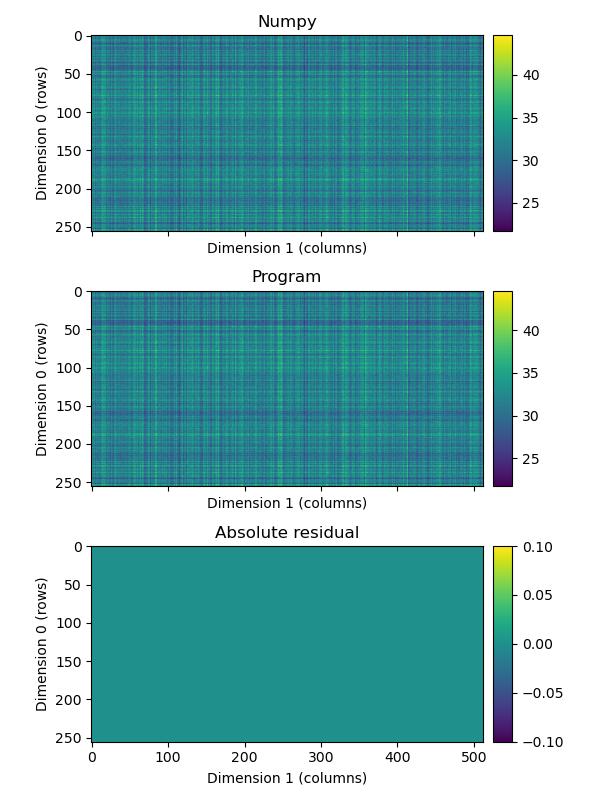

In [11]:
mat_mul.load_data()
mat_mul.check_data()

### OpenCL 1.x atomics

OpenCL 1.x has basic support for atomic operations. Documentation is available [here](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/atomicFunctions.html) and the operations are for use within a kernel to ensure atomic operations are conducted across work items. These functions mostly operate on signed or unsigned integers that are part of the global or local address space.

In the file [atomics.cpp](atomics.cpp) is an example of OpenCL 1.x atomics in operation. We create a buffer_T that is the size of cl_uint and increment it atomically in the **atomic_test** kernel in [kernels_atomics.c](kernels_atomics.c).

```C++
// Kernel to test atomics
__kernel void atomics_test1 (__global unsigned int* T) {
    
    // Increment T atomically
    atomic_add(T, 1);
}
```


### Memory synchronisation in OpenCL 2.0+ - atomics and fences

OpenCL 1.x has a **relaxed** memory model. It means that consistency between items in a workgroup is only guaranteed at a workgroup barrier, and consistency between host and device memory is only guaranteed at synchronisation points like **clFinish** or **clWaitForEvents** or after blocking memory copies. There are basic atomic functions within OpenCL 1.x, however with the introduction of OpenCL 2.0 there needed to be more sophisticated synchronisation between host and device. OpenCL 2.0+ has two types of synchronisation constructs.

* Fences
* Atomic operations

In the code [atomics2.cpp](atomics2.cpp) is an equivalent operation to the atomics from the example above. Instead we use an atomic type **std::atomic_uint from** **\<atomic\>** as the initialised memory for **Buffer_T**. 

```C++
    // atomics2.cpp:82

    // Make an atomic counter
    std::atomic_uint value_T = { 0 };

    // Make some global memory for an atomic operation
    cl_mem buffer_T = clCreateBuffer(
        context, 
        CL_MEM_READ_WRITE | CL_MEM_COPY_HOST_PTR, 
        sizeof(std::atomic_uint), 
        &value_T, 
        &errcode
    );
    h_errchk(errcode, "Creating buffer_T");
```

Then, in the kernel in file [kernels_atomics2.c](kernels_atomics2.c) we use the OpenCL 2.0+ function **atomic_fetch_add** to increment the counter.

```C++
// kernels_atomics2.c:0

// Kernel to test OpenCL atomics v2.0
__kernel void atomics_test2 (__global atomic_uint* T) {
      
    // Increment T atomically using OpenCL 2.0
    atomic_fetch_add(T, 1);
}
```

Since this is OpenCL 2.0+ kernel code we need to include the **"-cl-std=CL2.0"** build flag in [atomics2.cpp](atomics2.cpp)

```C++
    // atomics2.cpp:102

    // Turn this source code into a program
    cl_program program = h_build_program(kernel_source, context, device, "-cl-std=CL2.0");
```

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Research Centre</a>. All trademarks mentioned are the property of their respective owners.
</address>